# Basic depiction of a FEP workflow using BioSimSpace and Python

In [23]:
import BioSimSpace as BSS
import glob
from IPython.display import Image

BSS.__version__

'2020.1.0'

## 1. Load ligands and protein into memory.

Loading ligands and protein structures can be done using BSS API.

In [10]:
path_to_protein = "inputs/protein/ROS1.pdb"
path_to_ligands = "inputs/ligands/"

# redo this with pre-param ligands now in inputs/


# # load the protein.
# protein = BSS.IO.readPDB(path_to_protein)

# # loading all the ligands is a bit more involved. The simplest way is to glob over all ligand paths
# # and load them into a dictionary so that we can pick molecules when we set up edges later on.
# ligands_dict = {}
# for ligand_path in glob.glob(path_to_ligands):
    
#     # first, derive the ligand name.
#     ligand_name = ligand_path.split("/")[-1].replace(".mol2", "")
    
#     # make an entry in our dictionary with the ligand name and the loaded molecule.
#     ligands_dict[ligand_name] = BSS.IO.readMolecules(ligand_path)
    
# print("Number of loaded ligands:", len(ligands_dict))

/home/jscheen/miniconda3/envs/sire/lib/python3.7/site-packages/pypdb/pypdb.py:517: UserWarning: Retrieval failed, returning None
  warnings.warn("Retrieval failed, returning None")


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpgntlj_6t/INPUTS/PROTEIN/ROS1.PDB.pdb'

## 3. Determine which edges to run using LOMAP.


We'll use LOMAP to pick edges between our ligands. There are several ways to run LOMAP through python, but the simplest option is to use the commandline:
  

In [24]:
%%bash
# this will take several seconds to run.
python lomap_networkgen.py inputs/ligands/ -n outputs/lomap/out -v off 

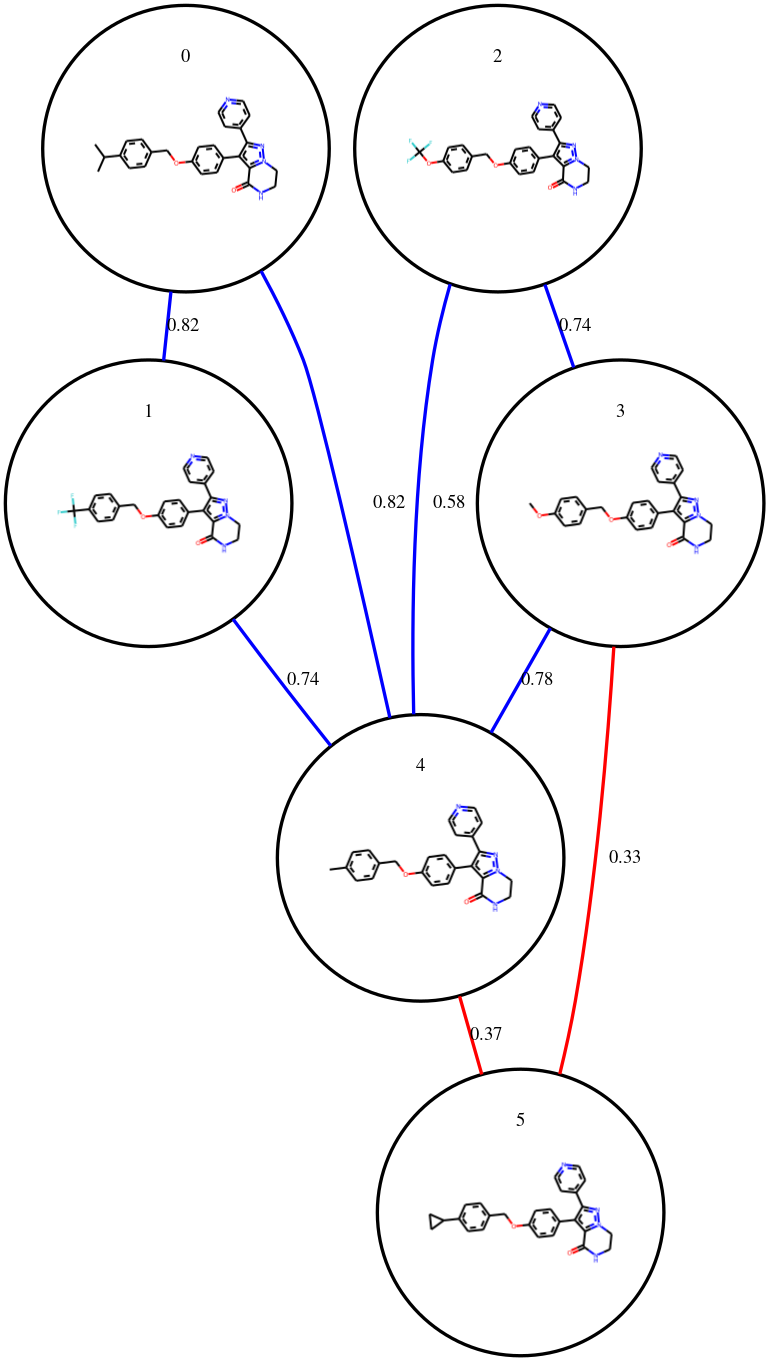

In [21]:
Image(filename="outputs/lomap/out.png", width = 500)

In [ ]:
# get the file with edges, use a quick function to extract edges. 
# adjust lomap to take ligand names instead of index in graph.
# in next cell, add an edge between 5 and 1, e.g. 
# or shall we just do all this in networkx?

## 4. Set up SOMD simulation folders.


In [12]:
# Define the Free Energy protocol. Here we use BSS's standard settings.
# see https://biosimspace.org/api/generated/BioSimSpace.Protocol.FreeEnergy.html#BioSimSpace.Protocol.FreeEnergy 
protocol = BSS.Protocol.FreeEnergy()

In [13]:
# We can loop over each transformation and do the standard BSS setup protocol.
for pert in transformations:
    # derive the perturbation name (to name our simulation folder).
    pert_name = pert[0]+"~"+pert[1]
    
    # get the molecule objects from our dictionary.
    ligand_A = ligands_dict[pert[0]]
    ligand_B = ligands_dict[pert[1]]
    
    # generate a mapping between the two molecules.
    mapping = BSS.Align.matchAtoms(ligand_A, ligand_B)
    
    # align ligand A to ligand B.
    ligand_A_a = BSS.Align.rmsdAlign(ligand_A, ligand_B, mapping)
    
    # merge the aligned molecules into a single object.
    merged = BSS.Align.merge(ligand_A_a, ligand_B, mapping,
                                        allow_ring_breaking=True,
                                        allow_ring_size_change=True
                                        )
    
    # insert the merged molecules into the protein and solvate the system.
    system = protein_p + merged
    system_s = BSS.Solvent.tip3p(molecule=system, box=3*[10*BSS.Units.Length.nanometer])
    
    # set up a SOMD folder with standard settings.
    # if you want to run replicates here, a simple iteration loop that with work_dir=pert_name+str(i) would work.
    BSS.FreeEnergy.Binding(
                                            system_s, 
                                            protocol, 
                                            engine="SOMD",
                                            work_dir=pert_name
                                            )

## 5. Run simulations & gather MBAR results from simulation outputs.

The collection of set up SOMD folders can be run in parallel on e.g. a computing cluster with slurm. An example job script for such a system would like this:

In [14]:
## insert slurm script here. Preferably this will be a script that loads the SOMD env, 
# does freenrg.run() and freenrg.analyse() (does analyse write out freenrg-MBAR.dat files?)

# if that implementation is too complex, I always run ~/biosimspace.app/bin/somd-freenrg and subsequently mbar
# directly in each lambda folder. 

## 6. Compute statistics and plot validations.

In [ ]:
# use freenrgworkflows? might be easy to build into BSS. Otherwise a standard set of functions using basic plt
# could work too. 